One of the most important tasks for any retail store company is to analyze the performance of its stores. The main challenge faced by any retail store is predicting in advance the sales and inventory required at each store to avoid over-stocking and under-stocking. This helps the business to provide the best customer experience and avoid getting into losses, thus ensuring the store is sustainable for operation.

In this notebook, I’ll using Rossmann store data available on Kaggle.

Rossmann operates over 3,000 drug stores in 7 European countries. The challenge is to predict their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.

Part 1. 

Exploratory Data Analysis

In [12]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
# from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Importing store data
store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


The above table gives us information about 1115 stores owned by Rossman.

In [18]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [22]:
store.duplicated().sum()

0

In [23]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [24]:
store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [25]:
store.shape

(1115, 10)

In [26]:
store.info

<bound method DataFrame.info of       Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
1         2         a          a                570.0   
2         3         a          a              14130.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
...     ...       ...        ...                  ...   
1110   1111         a          a               1900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
1                          11.0                    2007.0       1   
2                          12.0                    2006.0       1   
3      

In [28]:
# Importing train data
train = pd.read_csv('train.csv', index_col='Date', parse_dates = True)
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [29]:
train.columns


Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [30]:
train.dtypes

Store             int64
DayOfWeek         int64
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [31]:
train.shape

(1017209, 8)

We can see from the above table that the date is one of the columns. What makes this analysis unique is that ‘Date’ is one of the important factors influencing sales and it acts as an independent variable. To put it simply, this is a time-series data i.e a series of data points ordered in time.


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [34]:
train.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [35]:
train.duplicated().sum()

152740

In [36]:
train = train.drop_duplicates()

In [37]:
train.duplicated().sum()

0

In [38]:
train['StateHoliday'].value_counts()

0    733329
0    113647
a     11890
c      3183
b      2420
Name: StateHoliday, dtype: int64

In [40]:
train.shape

(864469, 8)

<Axes: ylabel='Frequency'>

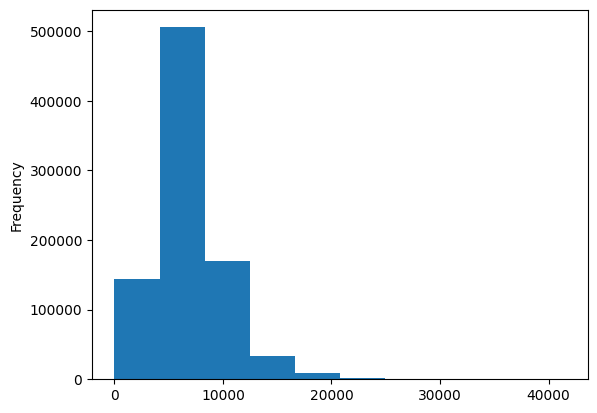

In [41]:
train['Sales'].plot(kind = 'hist')

In [44]:
# Checking train data
train.head(5).append(train.tail(5))

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


In [45]:
# Extracting year, month, day and week, and making new column
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

train['SalePerCustomer'] = train['Sales']/train['Customers']

In [46]:
# Checking train data again
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [47]:
# Checking data when the stores were closed
train_store_closed = train[(train.Open == 0)]
train_store_closed.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


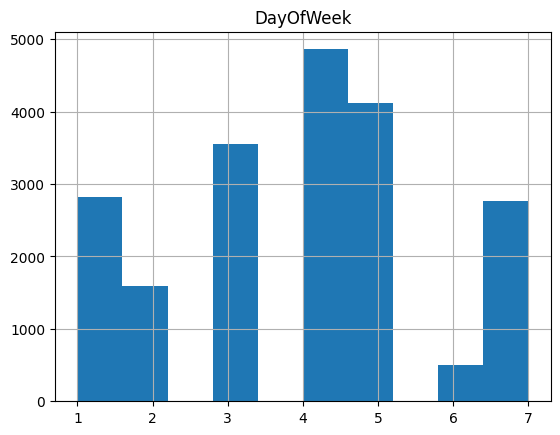

In [48]:
# Checking days when the stores were closed
train_store_closed.hist('DayOfWeek');

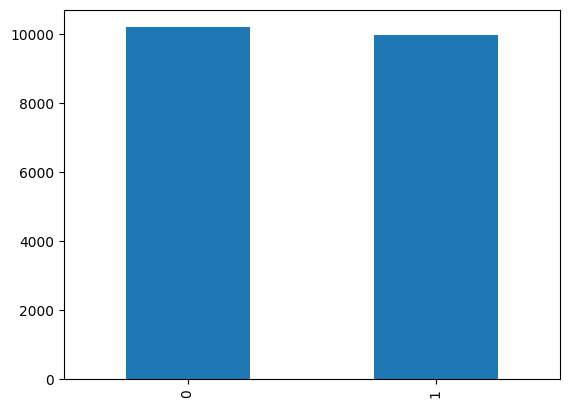

In [49]:

# Checking whether there was a school holiday when the store was closed
train_store_closed['SchoolHoliday'].value_counts().plot(kind='bar');

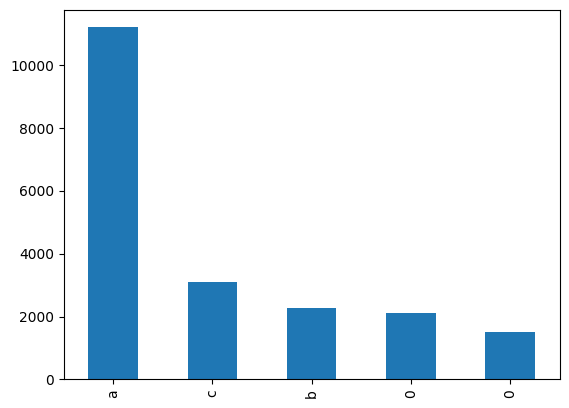

In [50]:
# Checking whether there was a state holiday when the store was closed
train_store_closed['StateHoliday'].value_counts().plot(kind='bar');

We can see from the above plot that stores were mostly closed on 7th day i.e Sunday and it makes sense. On other days, they were closed because of a school holiday or/and a state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None).

In [51]:
# Checking missing values in train set - no missing value
train.isnull().sum()

Store                  0
DayOfWeek              0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
Year                   0
Month                  0
Day                    0
WeekOfYear             0
SalePerCustomer    20246
dtype: int64

In [52]:
# No. of days when store was opened but zero sales - might be because of external factors or refurbishmnent
train[(train.Open == 1) & (train.Sales == 0)].shape[0]

54

In [53]:
# Checking store data
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [54]:
# Checking missing values in store data 
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Only 3 observations have 'Competition Distance' missing. This is probably because someone didn't enter the information in the system. It's safe to replace these missing values with the median. We can't use the same approach with competition's existence (month and year) as it doesn't make sense. It is better to replace it with 0 (i.e launched recently). We'll also impute the missing values in promo with 0 as no information about promo is avaialable.

In [55]:
# Replacing missing values for Competiton distance with median
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [56]:
# No info about other columns - so replcae by 0
store.fillna(0, inplace=True)

In [59]:
# Importing test data
test = pd.read_csv('test.csv')
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [60]:
# Checking missing values
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [61]:
test.shape

(41088, 8)

In [62]:
test.duplicated().sum()

0

In [63]:
# Assuming stores open in test
test.fillna(1, inplace=True)

In [64]:
# Joining the tables
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [65]:
# Distribution of sales and customers across store types
train_store_joined.groupby('StoreType')['Customers', 'Sales', 'SalePerCustomer'].sum().sort_values('Sales', ascending=False)

,Customers,Sales,SalePerCustomer
StoreType,,,
a,363504895,3165008779,4.042473e+06
d,156886969,1765198333,2.918002e+06
c,92121276,783152809,9.743973e+05
b,31465621,159231395,7.987612e+04


Let's see the stores which are closed or have zero sales.

In [66]:
# Closed and zero-sales obseravtions
train_store_joined[(train_store_joined.Open ==0) | (train_store_joined.Sales==0)].shape

(20248, 22)

So, we have 20248 observations when the stores were closed or have zero sales. We can drop these rows in order to do data analysis but we can still keep them for predictive modelling because our models will be able to understand the trend behind it.

In [67]:
# Open & Sales >0 stores
train_store_joined_open = train_store_joined[~((train_store_joined.Open ==0) | (train_store_joined.Sales==0))]

Correlation Analysis

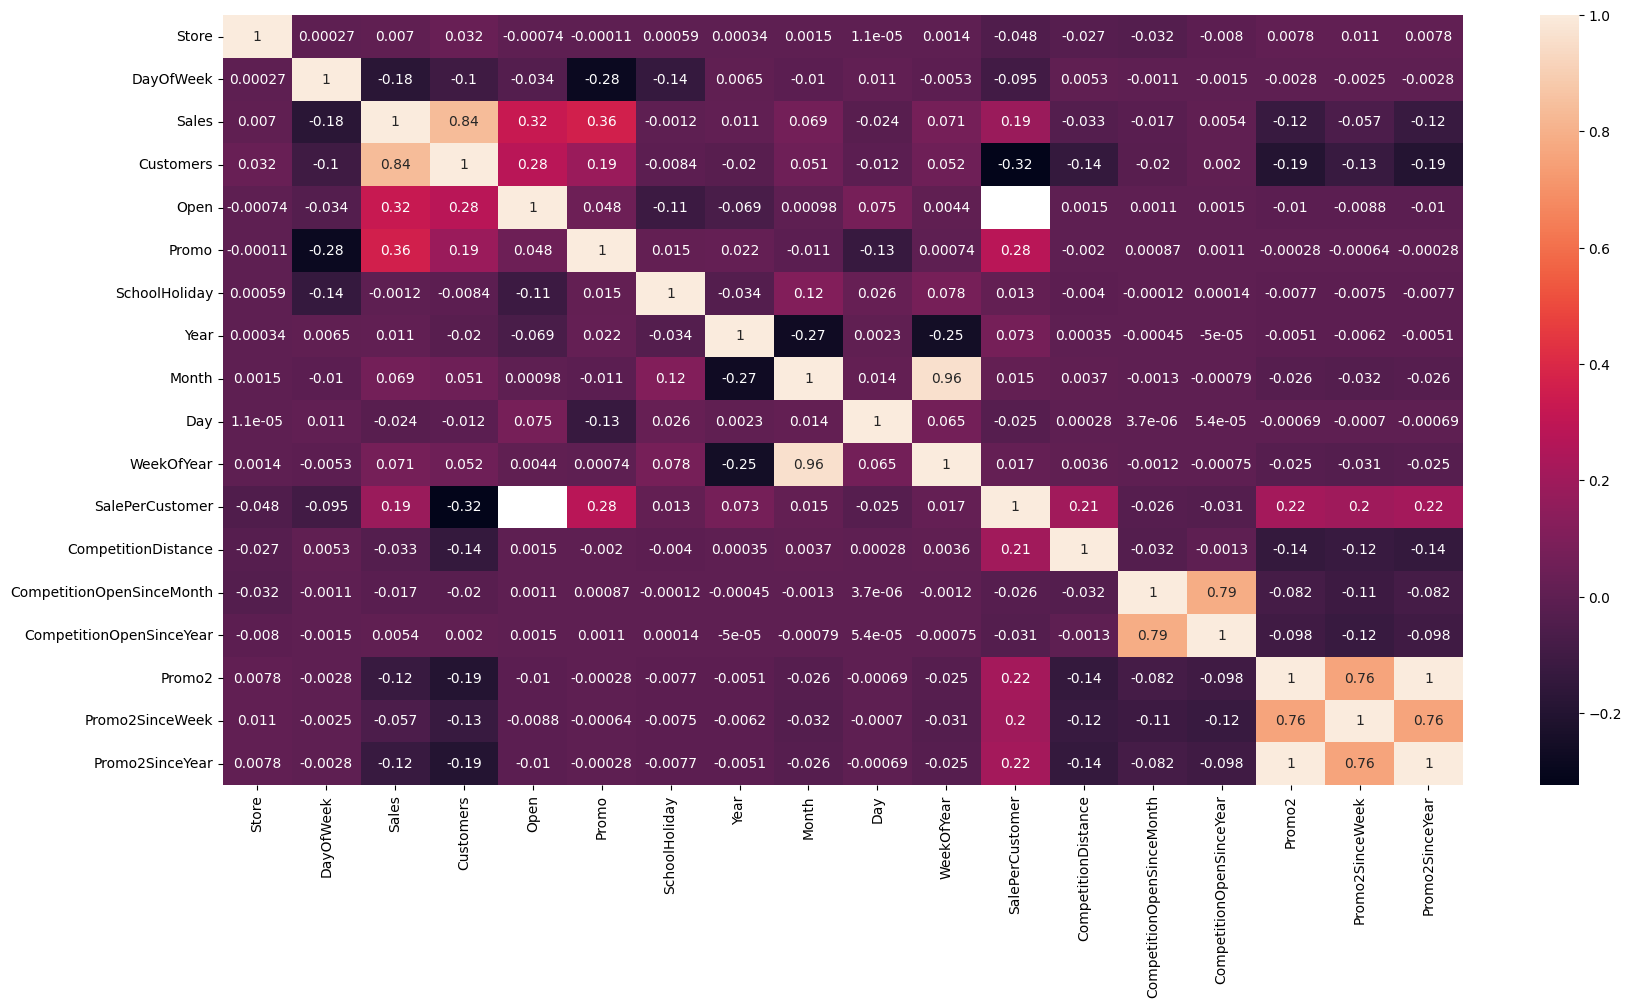

In [70]:
# Correlation
plt.figure(figsize = (20, 10))
sns.heatmap(train_store_joined.corr(), annot = True);

We can see a strong positive correlation between the amount of Sales and Customers visiting the store. We can also observe a positive correlation between a running promotion (Promo = 1) and number of customers.

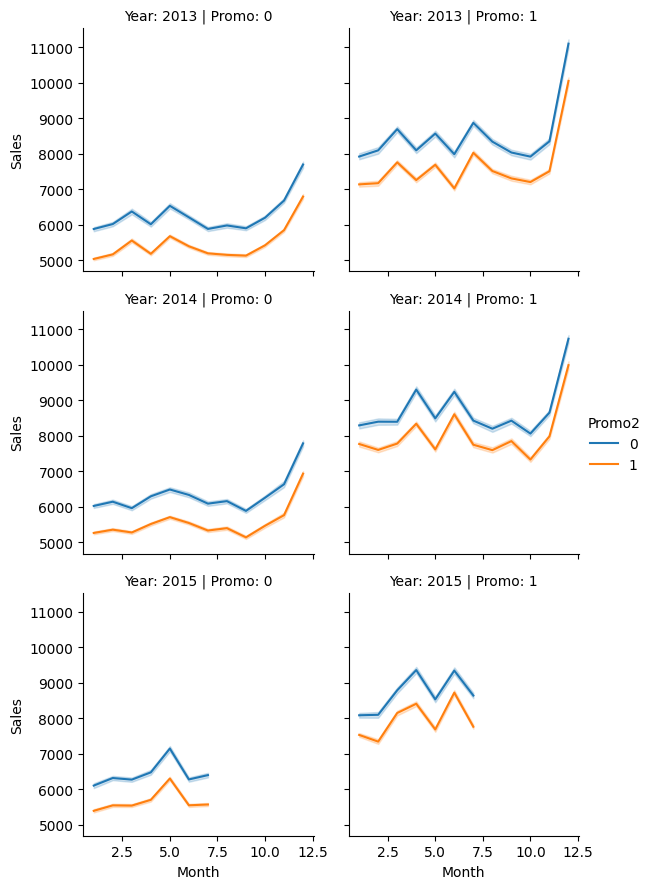

In [73]:
# Sales trend over the months and year using FacetGrid
g = sns.FacetGrid(data=train_store_joined_open, col='Promo', hue='Promo2', row='Year')
g.map_dataframe(sns.lineplot, x='Month', y='Sales')

# Customize the appearance
g.set_axis_labels('Month', 'Sales')
g.set_titles(col_template='Promo: {col_name}', row_template='Year: {row_name}')
g.add_legend()

plt.show()

Conclusions of EDA

a) The most selling and crowded StoreType is A.

b) StoreType B has the highest Sale per Customer.

c) Customers tends to buy more on Mondays when there are ongoing promotional offers and on Thursdays/Fridays when there is no promotion at all.

d) Second promotion (Promo2) doesn't seem to contribute in the increase of sales.

# Part B - Time Series Analysis & Predictive Modelling

Time Series Analysis
For Time Series Anlaysis , we will consider one store from each store type a , b , c , d that will represent their respective group. It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.

In [75]:
pd.plotting.register_matplotlib_converters()

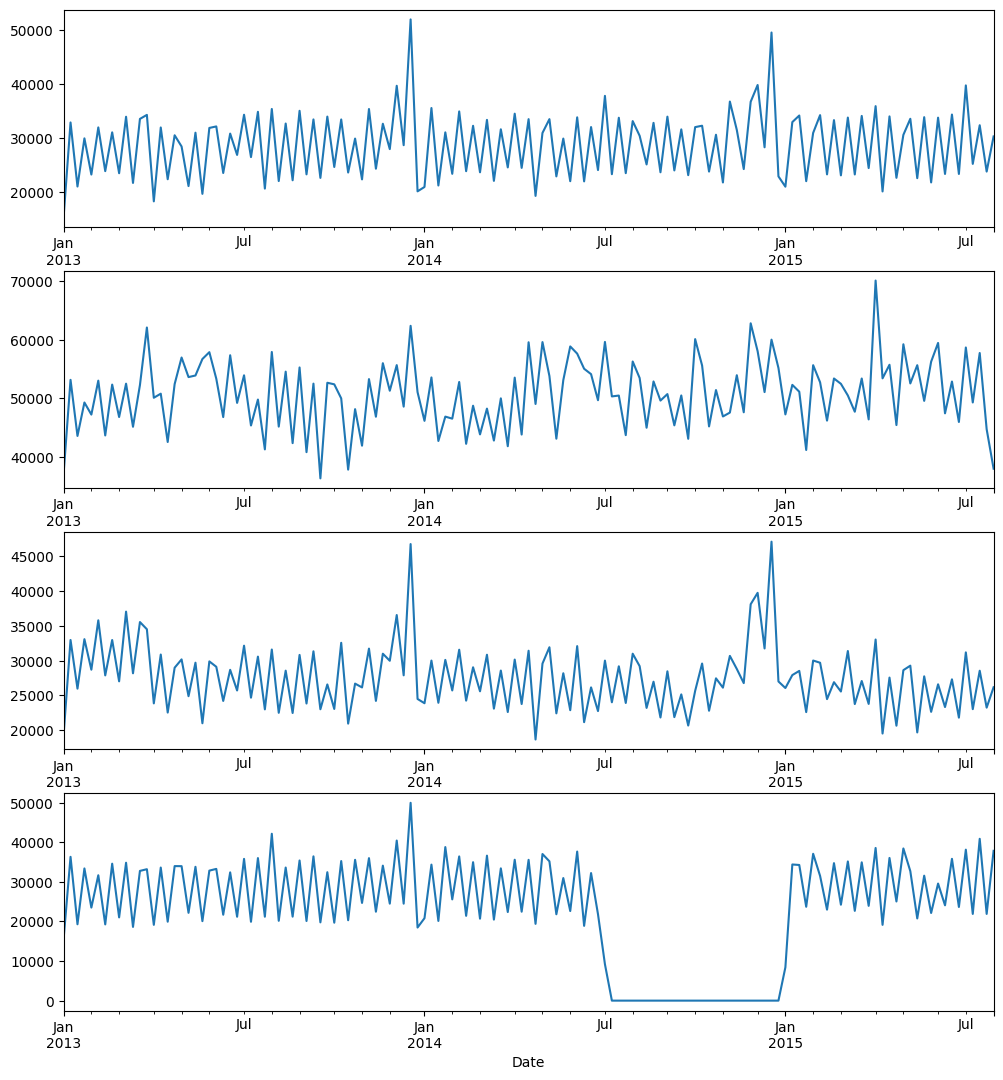

In [76]:
# Data Preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Trend
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4);

We can see from above plots that sales for StoreType A and C tend to peak in the end of year (Christmas season) and then decline after the holidays. We are not able to see a similar trend in StoreType D because no data is available for that time period (stores closed).

Stationarity of time series

In order to use time series forecasting models, we need to ensure that our time series data is stationary i.e constant mean, constant variance and constant covariance with time.

here are 2 ways to test the stationarity of time series
a) Rolling Mean: Visualization b) Dicky - Fuller test: Statistical test

Let’s check the stationarity of a store of type ‘a’.

In [77]:
# Function to test the stationarity
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

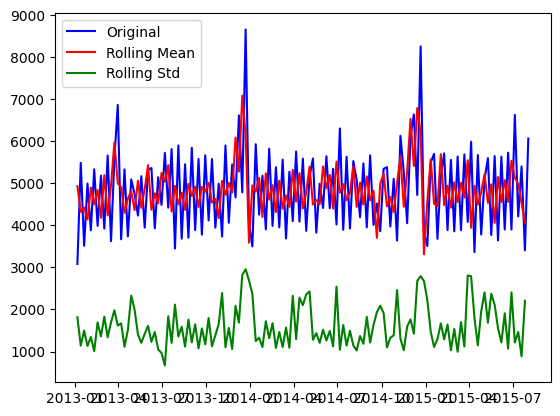

Results of Dickey-Fuller Test:
ADF Statistic: -6.240724
p-value: 0.000000
Critical Values:
1% -3.4387291412780177
5% -2.8652383048736056
10% -2.568739332674375


In [78]:
# Testing stationarity of store type a
test_stationarity(sales_a)

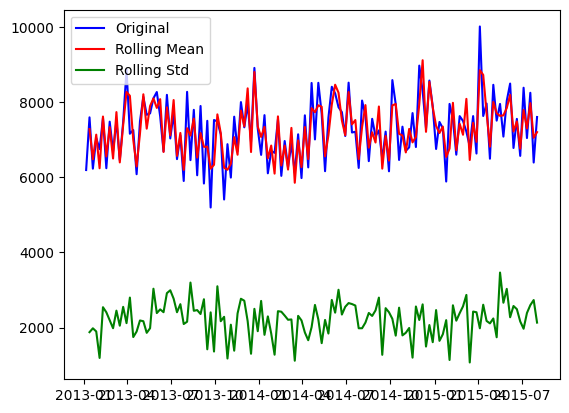

Results of Dickey-Fuller Test:
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [79]:
#Testing stationarity of store type b
test_stationarity(sales_b)

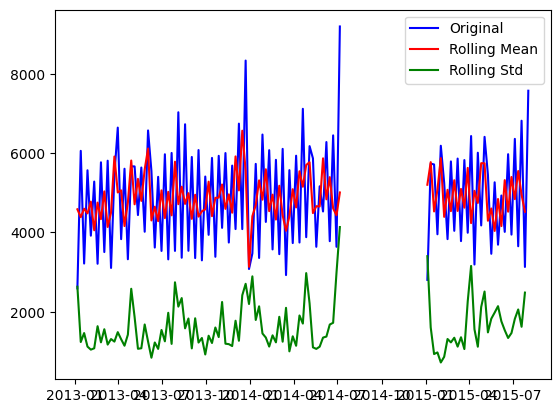

Results of Dickey-Fuller Test:
ADF Statistic: -7.006731
p-value: 0.000000
Critical Values:
1% -3.4407890899441127
5% -2.8661459340578905
10% -2.5692228868342766


In [80]:
#Testing stationarity of store type d
test_stationarity(sales_d)

We can see from the above plots and statistical tests that mean and variation doesn't change much with time, i.e they are constant. Thus, we don't need to perform any transformation (needed when time series is not stationary).

Now, let's check the trend and seasonality in our data.

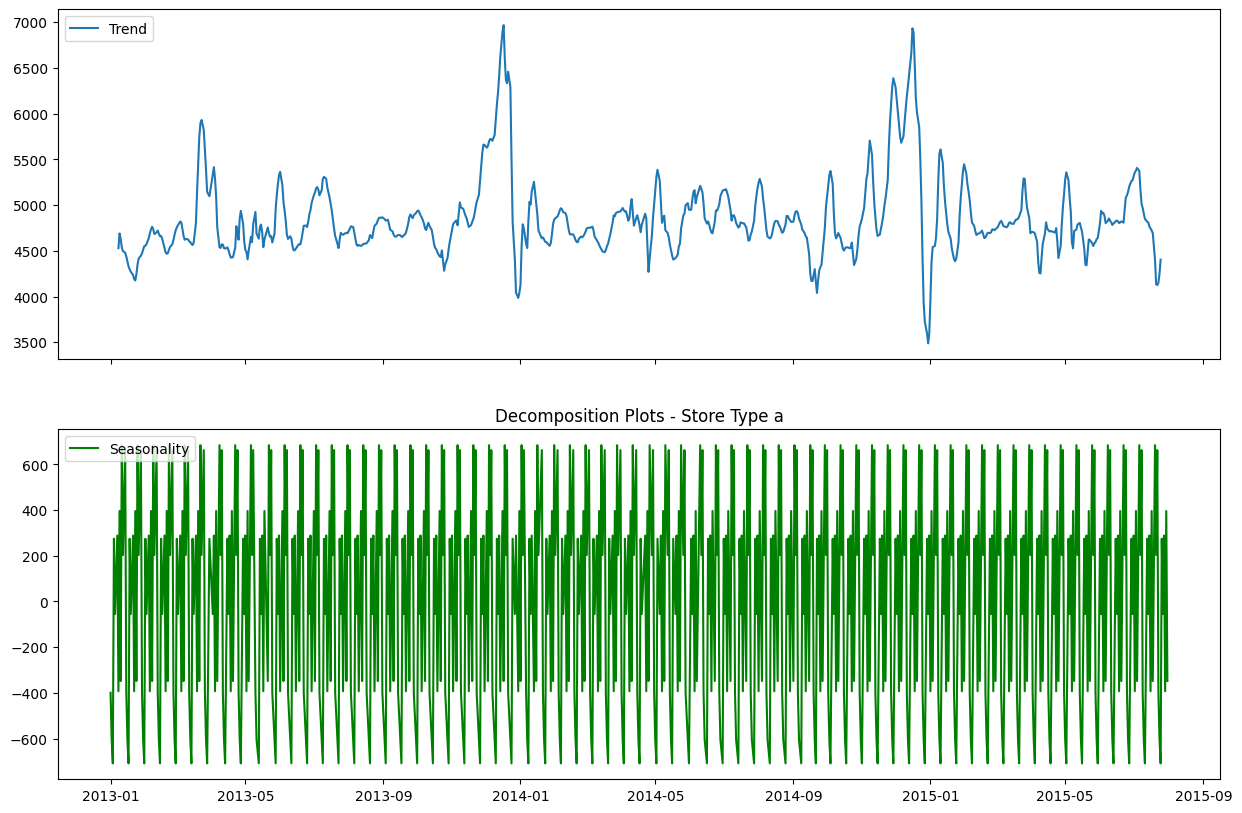

In [86]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'sales' has a datetime index
# sales.index = pd.to_datetime(sales.index)

def plot_timeseries(sales, StoreType):
    # Assuming 'sales' has a datetime index
    sales.index = pd.to_datetime(sales.index)
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 10))
    
    decomposition = seasonal_decompose(sales, model='additive', period=12)  # Adjust period according to your data frequency
    
    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left')
    
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left')

    plt.title(f'Decomposition Plots - Store Type {StoreType}')
    plt.show()

# Call the function with your sales data and store type
plot_timeseries(sales_a, 'a')


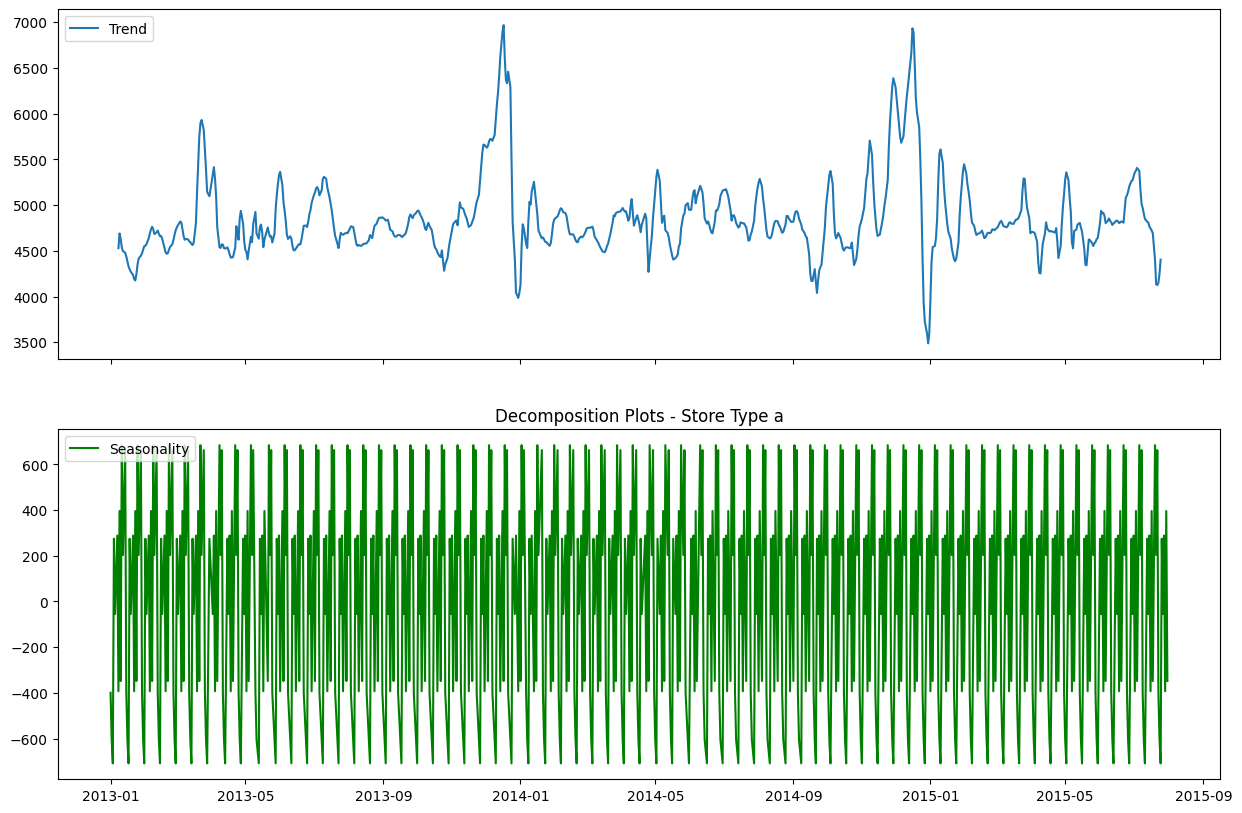

In [87]:
# Plotting seasonality and trend for store type a
plot_timeseries(sales_a,'a')

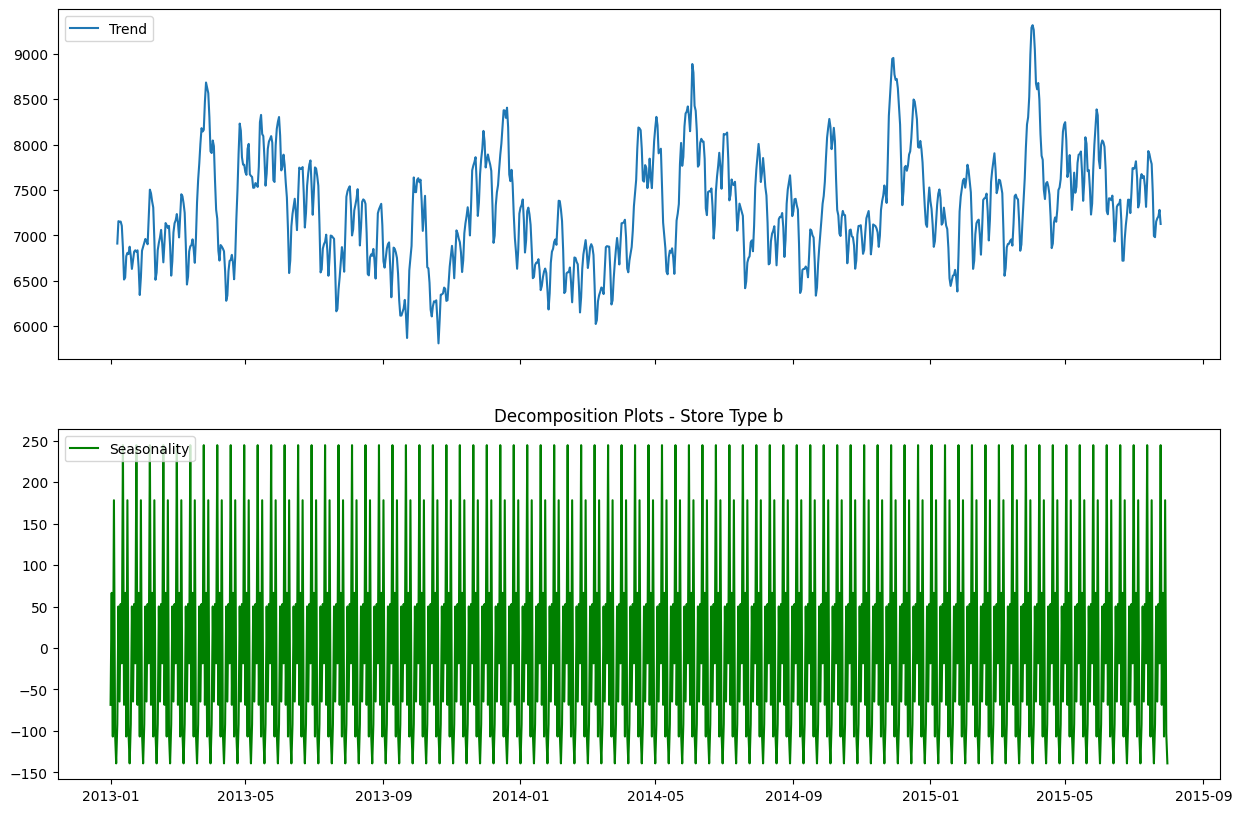

In [88]:
# Plotting seasonality and trend for store type b
plot_timeseries(sales_b,'b')

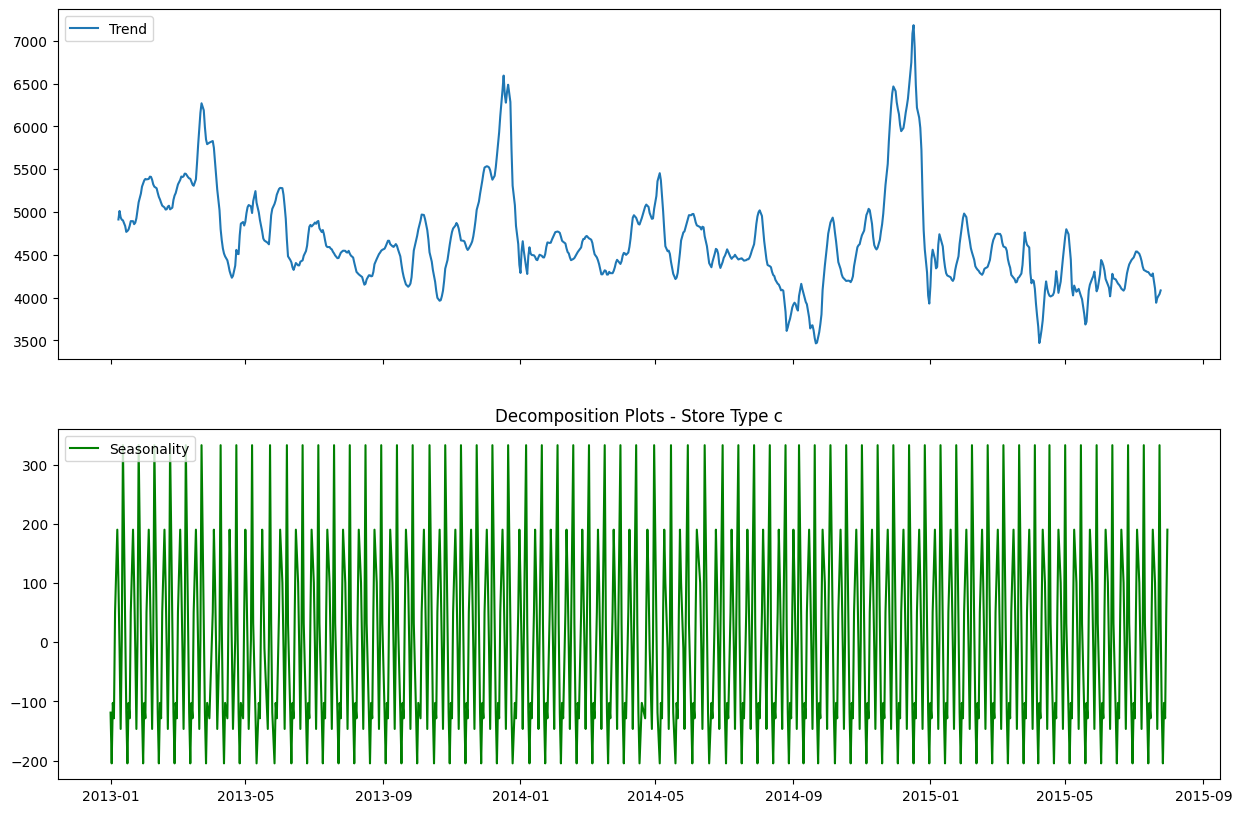

In [89]:
# Plotting seasonality and trend for store type c
plot_timeseries(sales_c, 'c')

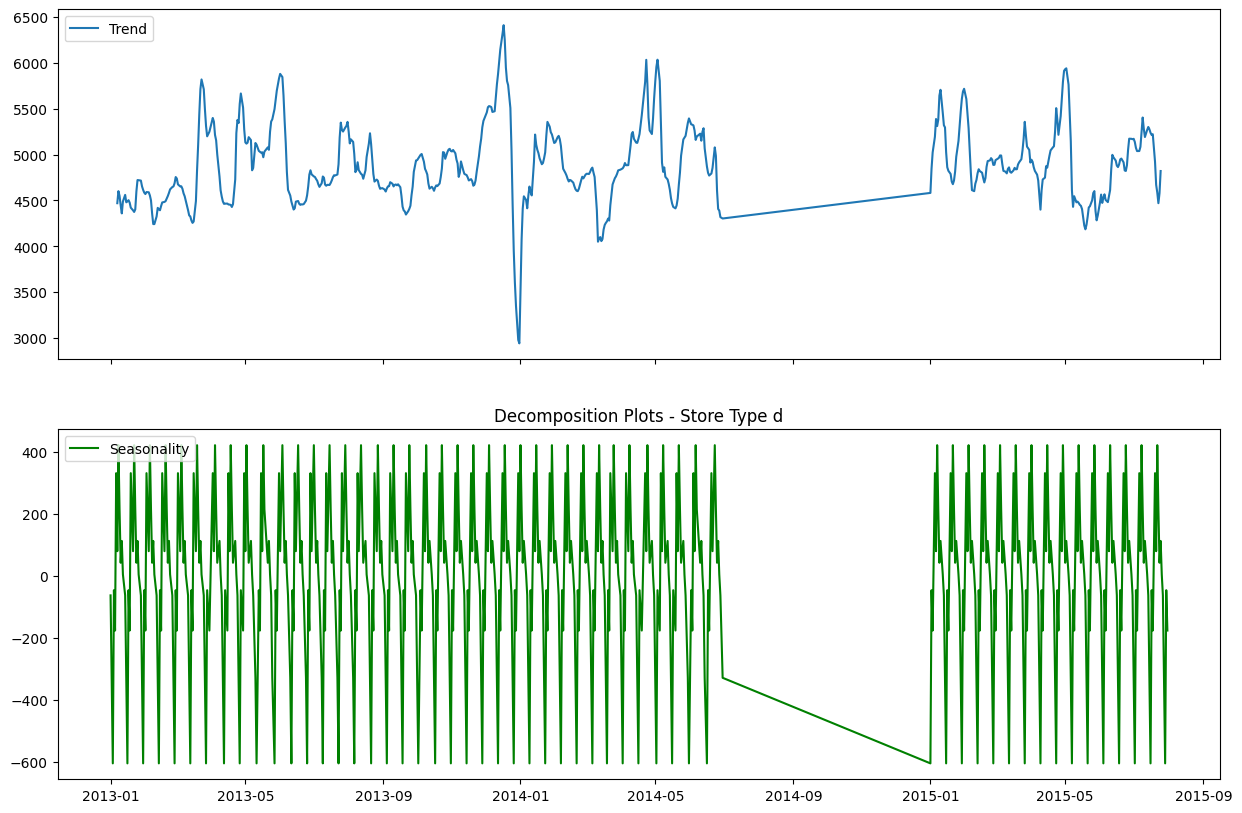

In [91]:
# Plotting seasonality and trend for store type d
plot_timeseries(sales_d, 'd')

From the above plots, we can see that there is seasonality and trend present in our data. So, we'll use forecasting models that take both of these factors into consideration. For example, SARIMAX and Prophet.

# Forecasting a Time Series
Evaluation Metrics

There are two popular metrics used in measuring the performance of regression (continuous variable) models i.e MAE & RMSE.

MAE - Mean Absolute Error: It is the average of the absolute difference between the predicted values and observed values.

RMSE - Root Mean Square Error: It is the square root of the average of squared differences between the predicted values and observed values.

MAE is easier to understand and interpret but RMSE works well in situations where large errors are undesirable. This is because the errors are squared before they are averaged, thus penalizing large errors. In our case, RMSE suits well because we want to predict the sales with minimum error (i.e penalize high errors) so that inventory can be managed properly.

So, let's choose RMSE as a metric to measure the performance of our models.

In [92]:
# Autocorrelation function to make ACF and PACF graphs
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('PACF')

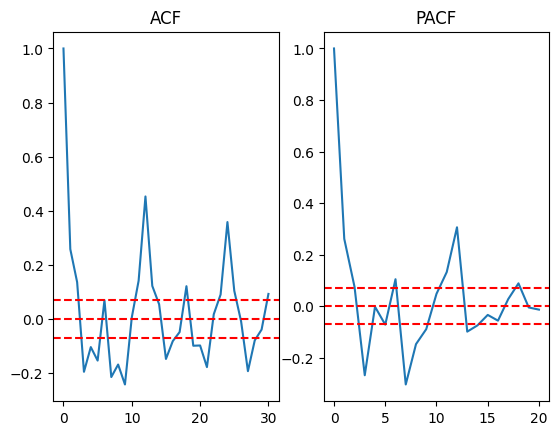

In [93]:
# ACF and PACF for store type a
auto_corr(sales_a)

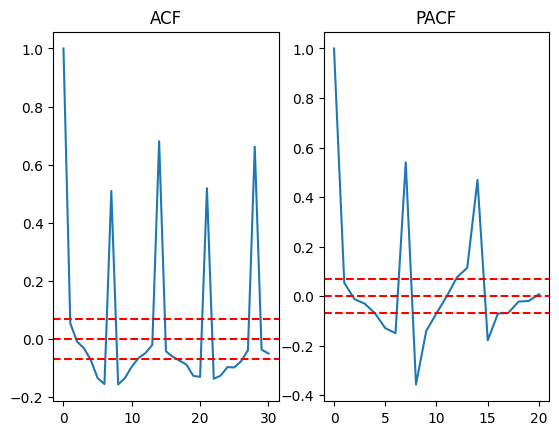

In [94]:
# ACF and PACF for store type b
auto_corr(sales_b)

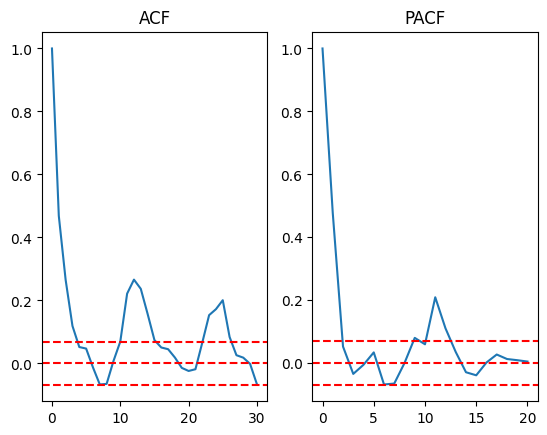

In [95]:
# ACF and PACF for store type c
auto_corr(sales_c)

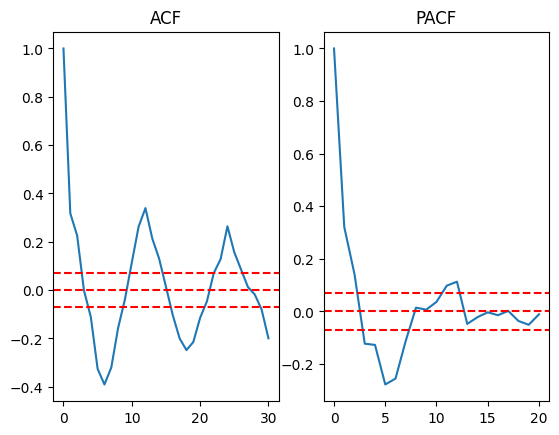

In [96]:
# ACF and PACF for store type d
auto_corr(sales_d)


The above graphs suggest that the p = 2 and q = 2 but let's do a grid search and see which combination of p, q and d gives the lowest Akaike information criterion (AIC, which tells us the quality of statistical models for a given set of data. Best model uses the lowest number of features to fit the data.

If we are to predict the sales of each store, we need to consider the whole data set rather than one store of each category. We took one store of each category to understand the tiem series data but from now on, we'll use the whole dataset for modelling.

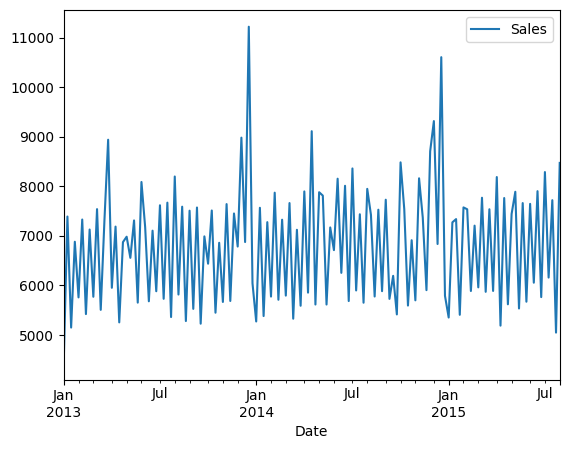

In [97]:
# Summing sales on per week basis
train_arima = train.resample("W").mean() 
train_arima = train_arima[["Sales"]]
train_arima.plot();

Hyperparamter tuning ARIMA model

As discussed above, we have three parameters (p, d and q) for SARIMA model. So, in order to choose the best combination of these parameter, we'll use a grid search. The best combination of parameters will give the lowest AIC score.

In [98]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Now, let's iterate through these combinations to see which one gives the lowest AIC score.

In [99]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2752.1749789174846
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2395.110951634678
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2180.7458326945807
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1927.5854775731902
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2204.1341406337006
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2159.153398978775
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1951.2994042596647
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1926.767100916974
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2663.3804795815468
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2341.8833460399524
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2148.399634532639
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1890.1729150901153
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2195.731902394975
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2128.64826220377
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1934.1801753974141
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1888.8575094503458
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2404.295933811064
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2185.3025699492355


We can see from the above grid search that our optimal parameter combination is ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1842.9253139506218. So, let's use this in our model.

Fitting the model - using hyperparamters tuned above

In [100]:
# Fitting the data to SARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5186      0.104     -4.986      0.000      -0.722      -0.315
ma.L1         -0.8597      0.043    -19.934      0.000      -0.944      -0.775
ma.S.L12      -1.0195      0.655     -1.557      0.120      -2.303       0.264
sigma2      1.208e+06   8.52e+05      1.419      0.156   -4.61e+05    2.88e+06


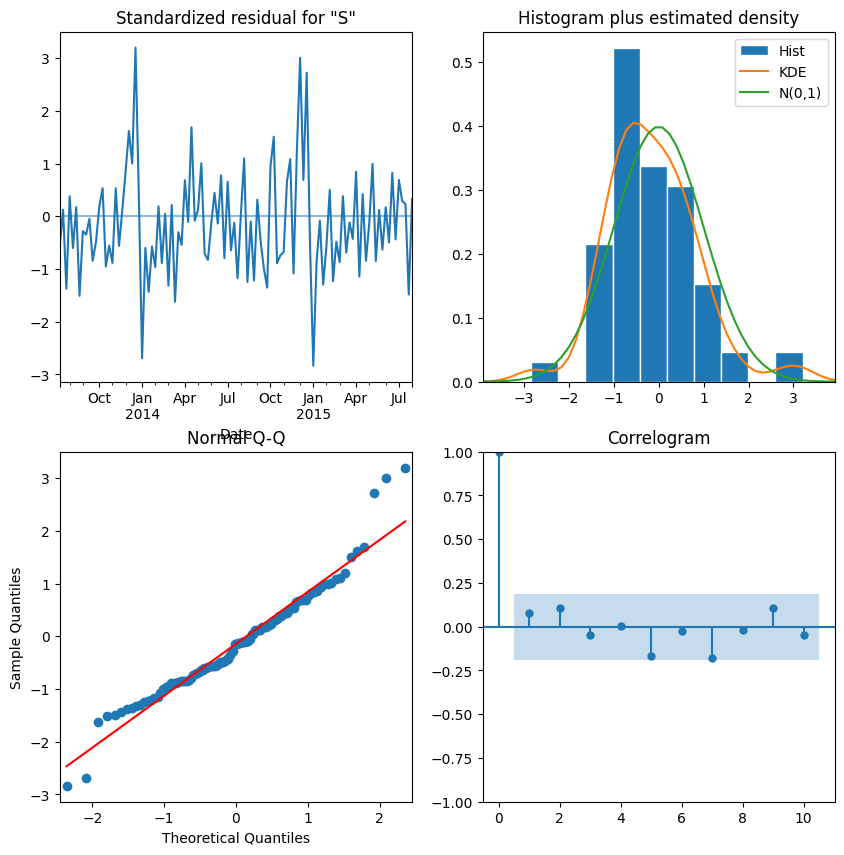

In [101]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

We can see from the above 'Histogram plus estimated density' plot that our KDE (Kernel Desnity Estimator) plot closely follows the N(0,1) normal distribution plot. The Normal Q-Q plot shows that the ordered distribution of residuals follows the distribution similar to normal distribution. Thus, our model seems to be pretty good.

Standardized residual plot tells us that there is no major seasonality trend, which is confirmed by Correlogram (autocorrelation) plot. Autocorrelation plot tells us that the time series residuals have low correlation with lagged versions of itself.

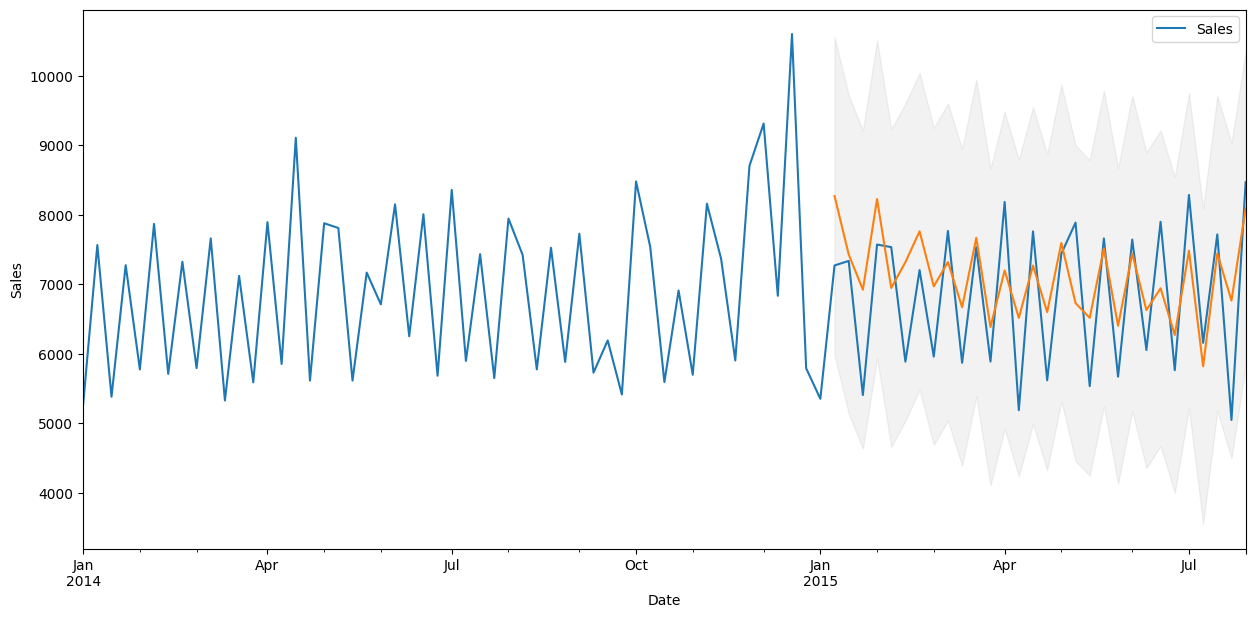

Root Mean Squared Error:  834.1394590602376


In [102]:
# Model Prediction and validation 
# Predictions are performed for the 11th Jan' 2015 onwards of the train data.

pred = results_sarima.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic = False) 

# Get confidence intervals of forecasts
pred_ci = pred.conf_int() 

ax = train_arima["2014":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima["2015-01-11":]

# Calculating the error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

Final ARIMA Solution:
We tried different combinations of parameters using Grid search and foundoptimal parameter: ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1842.9253. Let's try another model to see if we can reduce the error.

# Model 2 - XGBoost
We'll need to convert all categorical variables into numerical/dummy variables in order to implement XGBoost. We'll also drop columns that are correlated (e.g Customers, Sale Per Customer) in addition to merging similar columns into one column (CompetitionOpenSinceMonth, CompetitionOpenSinceYear).

In [103]:
# Dropping Customers and Sale per customer
ts_xgboost = train_store_joined.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'SalePerCustomer', 'PromoInterval'], axis=1)

In [104]:
# Combining similar columns into one column and dropping old columns
ts_xgboost['CompetitionOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.CompetitionOpenSinceYear) + (ts_xgboost.Month - ts_xgboost.CompetitionOpenSinceMonth)
ts_xgboost['PromoOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.Promo2SinceYear) + (ts_xgboost.WeekOfYear - ts_xgboost.Promo2SinceWeek) / 4.0
ts_xgboost = ts_xgboost.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)
ts_xgboost = ts_xgboost.drop(["Promo2SinceWeek", "Promo2SinceYear"], axis = 1)

In [105]:
# Converting categorical cols to numerical cols and removing old cols
mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis = 1)

In [106]:
# Splitting the data
features = ts_xgboost.drop(["Sales"], axis = 1)
target = ts_xgboost["Sales"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20) 

Initial/Baseline XGBoost

In [107]:
# Tuning parameters - using default metrics
params = {'max_depth':6, "booster": "gbtree", 'eta':0.3, 'objective':'reg:linear'} 

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost = xgb.train(params, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds = xgboost.predict(dtest)

[18:25:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5601.80863	eval-rmse:5601.14387
[1]	train-rmse:4353.23670	eval-rmse:4352.14220
[2]	train-rmse:3574.94884	eval-rmse:3574.56554
[3]	train-rmse:3120.65654	eval-rmse:3120.05543
[4]	train-rmse:2854.35298	eval-rmse:2854.10774
[5]	train-rmse:2712.36722	eval-rmse:2712.93498
[6]	train-rmse:2609.18227	eval-rmse:2610.73455
[7]	train-rmse:2559.89629	eval-rmse:2561.91007
[8]	train-rmse:2520.38120	eval-rmse:2523.24323
[9]	train-rmse:2502.30829	eval-rmse:2505.33830
[10]	train-rmse:2482.56731	eval-rmse:2485.08278
[11]	train-rmse:2455.23813	eval-rmse:2457.93614
[12]	train-rmse:2427.96786	eval-rmse:2430.88913
[13]	train-rmse:2418.09051	eval-rmse:2421.08858
[14]	train-rmse:2336.77134	eval-rmse:2343.41140
[15]	train-rmse:2324.62185	eval-rmse:2331.00962
[16]	train-

In [108]:
# RMSE of model
rms_xgboost = sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)

Root Mean Squared Error for XGBoost: 1247.2350309766994


Hypertuning XGBoost

Now let's try to decrease the RMSE of XGBoost by passing different values for our hyperparameters in the XGBoost model.

eta: It defines the learning rate i.e step size to learn the data in the gradient descent modeling (the basis for XGBoost). The default value is 0.3 but we want to keep the learning rate low to avoid overfitting. So, we'll choose 0.2 as eta
max_depth: Maximum depth of a tree. The default value is 6 but we want our model to be more complex and find good predictions. So, let's choose 10 as max depth.
gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. The default value is 0, let's choose a little higher value so as to get good predictions

In [114]:
# Tuning parameters
params_2 = {'max_depth':10, 'eta':0.2,  'gamma': 2}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost_2 = xgb.train(params_2, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds_2 = xgboost_2.predict(dtest)


[0]	train-rmse:6203.08238	eval-rmse:6203.32002
[1]	train-rmse:5177.81022	eval-rmse:5179.73130
[2]	train-rmse:4388.73034	eval-rmse:4393.36866
[3]	train-rmse:3795.99779	eval-rmse:3802.52880
[4]	train-rmse:3347.76718	eval-rmse:3356.44681
[5]	train-rmse:3030.21418	eval-rmse:3041.21140
[6]	train-rmse:2782.53442	eval-rmse:2797.64955
[7]	train-rmse:2611.45948	eval-rmse:2628.79465
[8]	train-rmse:2477.60209	eval-rmse:2496.99715
[9]	train-rmse:2364.59179	eval-rmse:2385.45442
[10]	train-rmse:2290.90044	eval-rmse:2312.13306
[11]	train-rmse:2239.41744	eval-rmse:2261.65453
[12]	train-rmse:2198.07782	eval-rmse:2221.51157
[13]	train-rmse:2166.94551	eval-rmse:2191.53217
[14]	train-rmse:2120.04886	eval-rmse:2144.56408
[15]	train-rmse:2067.62049	eval-rmse:2091.96949
[16]	train-rmse:2027.50507	eval-rmse:2051.69098
[17]	train-rmse:2007.77964	eval-rmse:2033.35937
[18]	train-rmse:1924.32603	eval-rmse:1949.21499
[19]	train-rmse:1918.98481	eval-rmse:1943.88427
[20]	train-rmse:1856.21402	eval-rmse:1881.66285
[2

In [115]:
# RMSE of model
rms_xgboost_2 = sqrt(mean_squared_error(y_test, preds_2))
print("Root Mean Squared Error for XGBoost:", rms_xgboost_2)

Root Mean Squared Error for XGBoost: 884.2770729888599


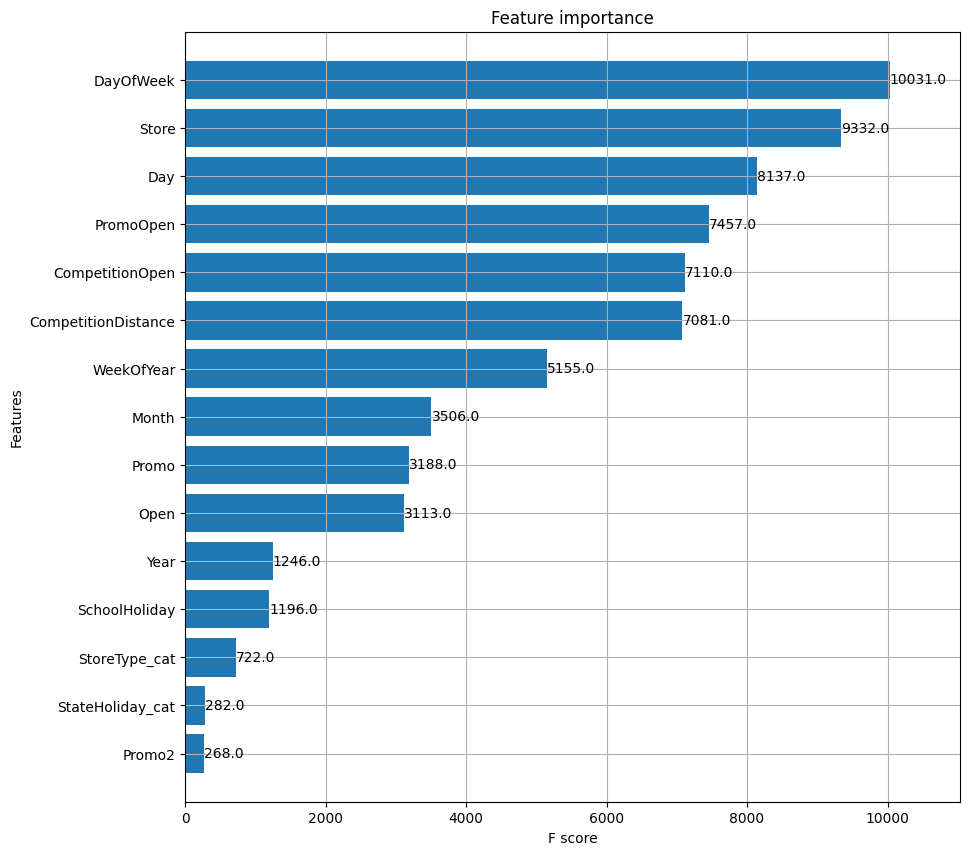

In [116]:
# Let's see the feature importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost_2, max_num_features=50, height=0.8, ax=ax)
plt.show()

Final XGBoost Model:
After hypertuning, we were able to reduce RMSE from 1247.2350309766994 to 884.2770729888599, which is great! Now, let's compare the performance of all models

Final Results

In [121]:
# Comparing performance of above three models - through RMSE
rms_arima = format(float(rms_arima))
rms_xgboost_2 = format(float(rms_xgboost_2))

model_errors = pd.DataFrame({
    "Model": ["SARIMA", "XGBoost"],
    "RMSE": [rms_arima, rms_xgboost_2]
})

model_errors.sort_values(by = "RMSE")

,Model,RMSE
0,SARIMA,834.1394590602376
1,XGBoost,884.2770729888599


# Model Comparison & Selection
We used the Root Mean Squared Error (RMSE) to evaluate and validate the performance of various models used. Let's see which model performed better and why/why not.

a) We can see from the above table that SARIMA performs the best followed by XGBoost and Prophet.

b) It makes sense because SARIMA is designed specifically for seasonal time series data while XGBoost is a general (though powerful) machine learning approach with various applications.


Based on the above analysis, we'll choose ARIMA as our final model to predict the sales because it gives us the least RMSE and is well suited to our needs of predicting time series seasonal data. We chose ARIMA(1, 1, 1)x(1, 1, 1, 12)12 as the final parameter combination with AIC of 1842.9253 and RMSE of 834.1394590602376.

# Conclusions
Our task was to predict the sales of each store for next month. We started by exploring the time series data and then did some feature engineering to prepare the data for modelling. Finally, we used various modelling techniques such as SARIMA, Prophet and XGBoost to predict the sales. SARIMA, a model designed specifically for time series performed the best. We also plotted the truth vs predicted sales to understand the performance of model in addition to calcualting squared mean error.

# Reflection
The most interesting thing about the project was that the category of stores having the highest sales don't have the highest sale per customer. It might be because those stores sell small items, which are needed on a daily basis.

Another interesting thing was that running a promotion for the second time doesn't help in increasing sales. It is probably because customers already purchased whatever they wanted during the first promotional sale.

# Improvement Areas:
We could have used the tranformation techniques to smoothen the data e.g using Moving Average, Log transformation etc. to remove seasonality and trend and make the time series more stationary. After building the model, we would have introduced the behavior of seasonality and trend back to the results. This might have resulted in a better model with a lower RMSE.

We could also use SARIMAX model that take exogenous variables. These are the variables whose value is determined outside the model and is imposed on the model. In other words, variables that affect a model without being affected by it. For example, Competition Open, Promo Open, etc.